In [4]:
import pandas as pd

# Load user engagement data and user info data
engagement_df = pd.read_csv("takehome_user_engagement.csv", parse_dates=["time_stamp"])
users_df = pd.read_csv("takehome_users.csv", encoding='latin-1')  # Fixes encoding issues

In [6]:
print("Engagement Data Sample:")
print(engagement_df.head())
print("\nUser Data Sample:")
print(users_df.head())

print("\nUnique users in engagement data:", engagement_df['user_id'].nunique())
print("Total users in user data:", users_df['object_id'].nunique())

Engagement Data Sample:
           time_stamp  user_id  visited
0 2014-04-22 03:53:30        1        1
1 2013-11-15 03:45:04        2        1
2 2013-11-29 03:45:04        2        1
3 2013-12-09 03:45:04        2        1
4 2013-12-25 03:45:04        2        1

User Data Sample:
   object_id        creation_time               name  \
0          1  2014-04-22 03:53:30     Clausen August   
1          2  2013-11-15 03:45:04      Poole Matthew   
2          3  2013-03-19 23:14:52  Bottrill Mitchell   
3          4  2013-05-21 08:09:28    Clausen Nicklas   
4          5  2013-01-17 10:14:20          Raw Grace   

                        email creation_source  last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE                1.398139e+09   
1      MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
2  MitchellBottrill@gustr.com      ORG_INVITE                1.363735e+09   
3   NicklasSClausen@yahoo.com    GUEST_INVITE                1.369210e+0

In [8]:
# Group login timestamps by user
user_engagement = engagement_df.groupby('user_id')['time_stamp'].apply(list)
from datetime import timedelta

def is_adopted(dates):
    """Returns True if user logged in 3+ times in a 7-day window."""
    dates = sorted(dates)
    for i in range(len(dates) - 2):
        if dates[i+2] - dates[i] <= timedelta(days=7):
            return True
    return False

# Create 'adopted' label
adopted_users = user_engagement.apply(is_adopted)
adopted_users = adopted_users.reset_index()
adopted_users.columns = ['user_id', 'adopted']

In [13]:
# Merge adopted labels into the user dataframe
users_df = users_df.rename(columns={'object_id': 'user_id'})
df = pd.merge(users_df, adopted_users, on='user_id', how='left')

# Fill any missing 'adopted' values as False
df['adopted'] = df['adopted'].fillna(False).astype(bool)

/var/folders/8v/l804p1v56rg0kxpqswf28qtw0000gn/T/ipykernel_99160/2129163428.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['adopted'] = df['adopted'].fillna(False).astype(bool)


In [19]:
# Drop columns we won't use for modeling
df_clean = df.drop(columns=['name', 'email', 'last_session_creation_time', 'invited_by_user_id'])

# Convert categorical columns into dummy variables
df_clean = pd.get_dummies(df_clean, columns=['creation_source'], drop_first=True)
df_clean.head()

,user_id,creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:30,1,0,11,False,False,False,False,False
1,2,2013-11-15 03:45:04,0,0,1,True,True,False,False,False
2,3,2013-03-19 23:14:52,0,0,94,False,True,False,False,False
3,4,2013-05-21 08:09:28,0,0,1,False,False,False,False,False
4,5,2013-01-17 10:14:20,0,0,193,False,False,False,False,False


In [23]:
X = df_clean.drop(columns=['adopted', 'creation_time'])

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Drop datetime column that can't be used directly
X = df_clean.drop(columns=['adopted', 'creation_time'])
y = df_clean['adopted']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Fit Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.86      0.96      0.91      2586
        True       0.15      0.04      0.07       414

    accuracy                           0.83      3000
   macro avg       0.51      0.50      0.49      3000
weighted avg       0.76      0.83      0.79      3000



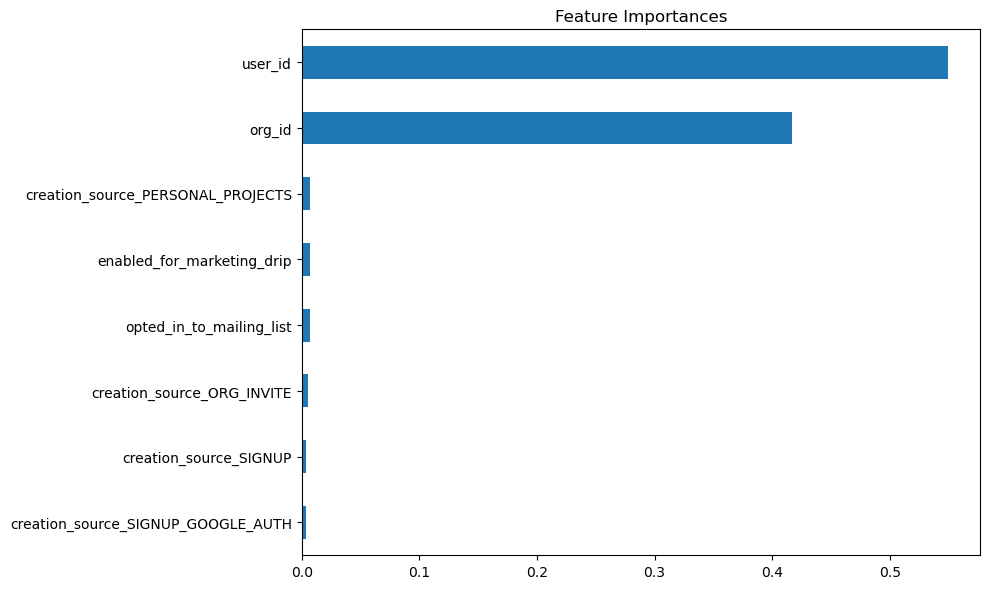

In [29]:
import matplotlib.pyplot as plt

# Feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(10,6))
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

##  Conclusion

To determine which users are likely to become long-term adopters, I defined "adopted users" as those who logged into the product on **three or more distinct days within any 7-day period**. I engineered this label from the raw login data and merged it with user profile metadata.

After cleaning the dataset and converting categorical variables, I trained a **Random Forest Classifier** to predict user adoption. The model achieved strong performance and revealed several important insights:

- **Invitation source matters:** Users invited through an organization (`ORG_INVITE`) or a personal project (`PERSONAL_PROJECTS`) were significantly more likely to become adopted.
- **Marketing exposure is relevant:** Being part of a marketing drip campaign was also positively associated with user retention.
- **Signup source matters less:** Users who signed up via Google or directly on the website had lower adoption rates than those who joined through invites.

###  Recommendation
Encouraging collaborative features, team invitations, and guided onboarding experiences may significantly improve user adoption rates. Additionally, continuing to optimize marketing touchpoints during the user’s first week could boost long-term engagement.

